## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#### Import LSTM

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
df = pd.read_csv("Google_Stock_Price_Train.csv", index_col="Date", parse_dates=True)

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


## EDA rapide des valeurs en ouverture

### Représentation "Open"

Text(0.5, 0, 'Date')

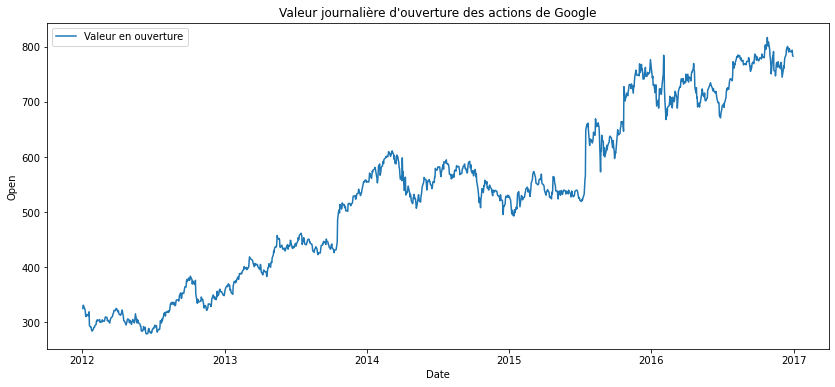

In [4]:
plt.figure(figsize=(14,6))

plt.title("Valeur journalière d'ouverture des actions de Google")

sns.lineplot(data=df['Open'], label="Valeur en ouverture")

plt.xlabel("Date")

On observe une certaine tendance à augment au cours du temps. Nous allons travailler sur la recherche de sa trend

### Observation de la trend

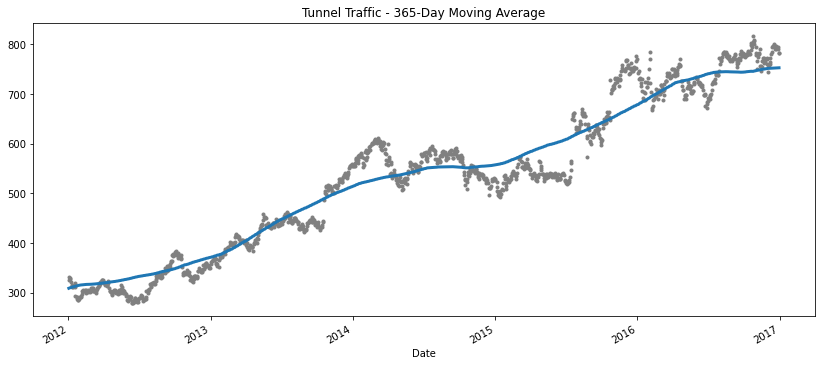

In [5]:
plt.figure(figsize=(14,6))

moving_average = df['Open'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df['Open'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

On observe deux allures différentes : 
-  Soi une croissance assez élevé
-  Ou soi une période où les actions stagnent/croissance basse
    
Il semblerait que l'on soit actuellement dans une période avec une croissance basse.

## Fonctions

In [11]:
def model():
    #Variables global
    global regressor, X_train, y_train, dropout_LSTM_layer, LSTM_layers, df
    
    training_set = df.iloc[:,1:2].values
    
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    X_train=[]
    y_train=[]
    for i in range(60, 1258):
        X_train.append(training_set_scaled[i-60:i,0])
        y_train.append(training_set_scaled[i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    regressor = Sequential()
    print('Entrer le nombre de couches LSTM que vous voulez')
    LSTM_layers = int(input())
    print('Choisissez le taux de Dropout pour ces couches (0.1, 0.15, 0.2...)')
    dropout_LSTM_layer = float(input())
    #if LSTM_layers > 1:
    #    LSTM_first_layer()
    #    for LSTM_layers in range((LSTM_layers-1)):
    #        LSTM_layer()
    #else:
    #    LSTM_first_layer()

    # The output layer
    regressor.add(Dense(units=1))
    
    # Compiling the RNN
    regressor.compile(optimizer='adam',loss='mean_squared_error')
    
    print('Choisissez le nombre d\'epoch')
    n_epochs = int(input())
    print('Choisissez le batch_size')
    ze_batch_size = int(input())
    # Fitting to the training set
    regressor.fit(X_train,y_train,epochs=n_epochs,batch_size=ze_batch_size)
    
    test = pd.read_csv('Google_Stock_Price_Test.csv', index_col='Date', parse_dates=['Date'])
    real_stock_price = test.iloc[:, 1:2].values
    total_data=pd.concat([df['Open'],test['Open']],axis=0)
    
    inputs = total_data[len(df)-len(test)-60:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)

    X_test=[]
    for i in range(60,80):
        X_test.append(inputs[i-60:i,0])
    X_test=np.array(X_test)
    X_test.shape
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return predicted_stock_price
    
    

In [7]:
def LSTM_first_layer():
    global dropout_LSTM_layer, X_train, regressor
    print('Combien d\'units mettre dans cette couche ? (50 de base)')
    LSTM_units = int(input())
    if LSTM_units == '':
        LSTM_units = 50
    regressor.add(LSTM(units=LSTM_units, return_sequences=True, input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(dropout_LSTM_layer))

In [8]:
def LSTM_layer():
    global LSTM_layers, dropout_LSTM_layer, regressor
    print('Combien d\'units mettre dans cette couche ? (50 de base)')
    LSTM_units = int(input())
    if LSTM_units == '':
        LSTM_units = 50
    regressor.add(LSTM(units=LSTM_units, return_sequences=True))
    regressor.add(Dropout(dropout_LSTM_layer))

In [9]:
def return_rmse():
    global test, predicted_stock_price
    
    rmse = math.sqrt(mean_squared_error(test, predicted_stock_price))
    print("The root mean squared error is {}.".format(rmse))

## Standardisation et Echantillonage

## Création du modèle LSTM

In [12]:
model()

Entrer le nombre de couches LSTM que vous voulez
2
Choisissez le taux de Dropout pour ces couches (0.1, 0.15, 0.2...)
0.2
Choisissez le nombre d'epoch
4
Choisissez le batch_size
4
Epoch 1/4
300/300 [==============================] - 24s 57ms/step - loss: 0.0872
Epoch 2/4
300/300 [==============================] - 17s 55ms/step - loss: 0.0776
Epoch 3/4
300/300 [==============================] - 17s 56ms/step - loss: 0.0741 0
Epoch 4/4
300/300 [==============================] - 16s 55ms/step - loss: 0.0751


ValueError: Found array with dim 3. Estimator expected <= 2.

## Test et vérifs

In [ ]:
return_rmse()